In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, Dropout
import matplotlib.pyplot as plt


In [12]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


<class 'tensorflow.python.framework.ops.EagerTensor'>


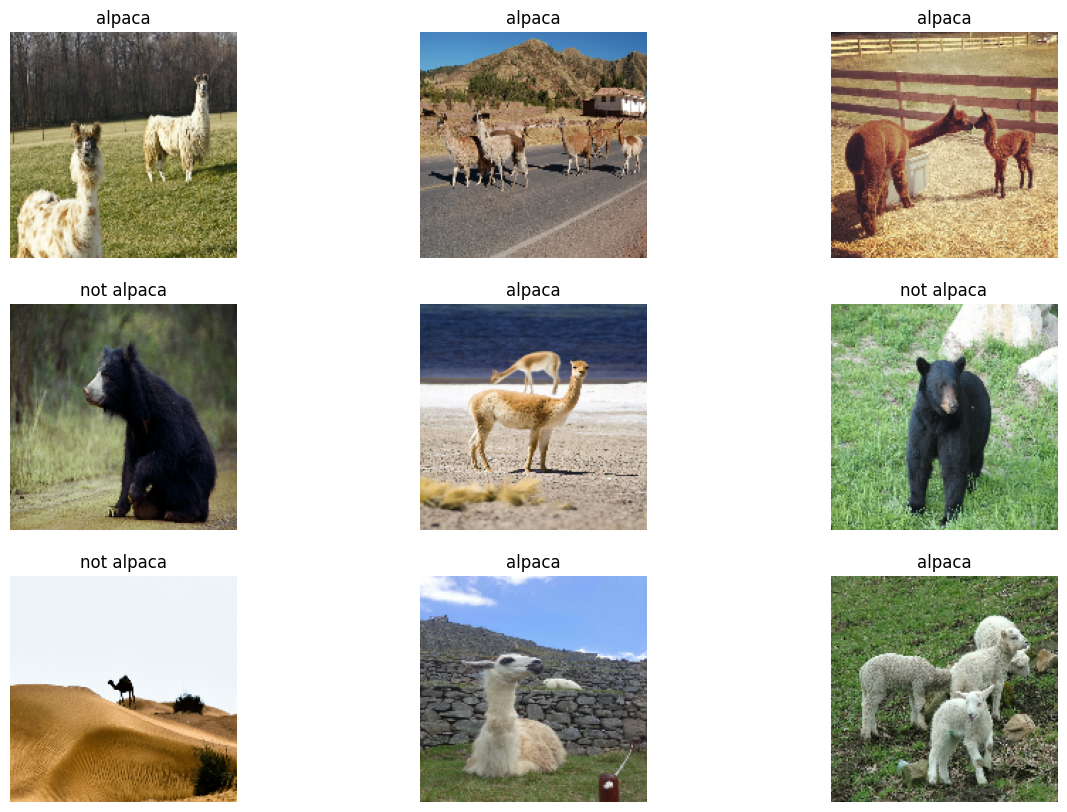

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # Use AUTOTUNE to let TensorFlow automatically tune the prefetch buffer size for best performance
train_dataset = train_dataset.prefetch(AUTOTUNE) # Prefetch the data to improve performance by preparing the next batch while the current batch is being processed


In [5]:
def DataAugmenter():
    data_augmentation = tf.keras.models.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2)) #  72 degree

    return data_augmentation

<class 'keras.src.models.sequential.Sequential'>


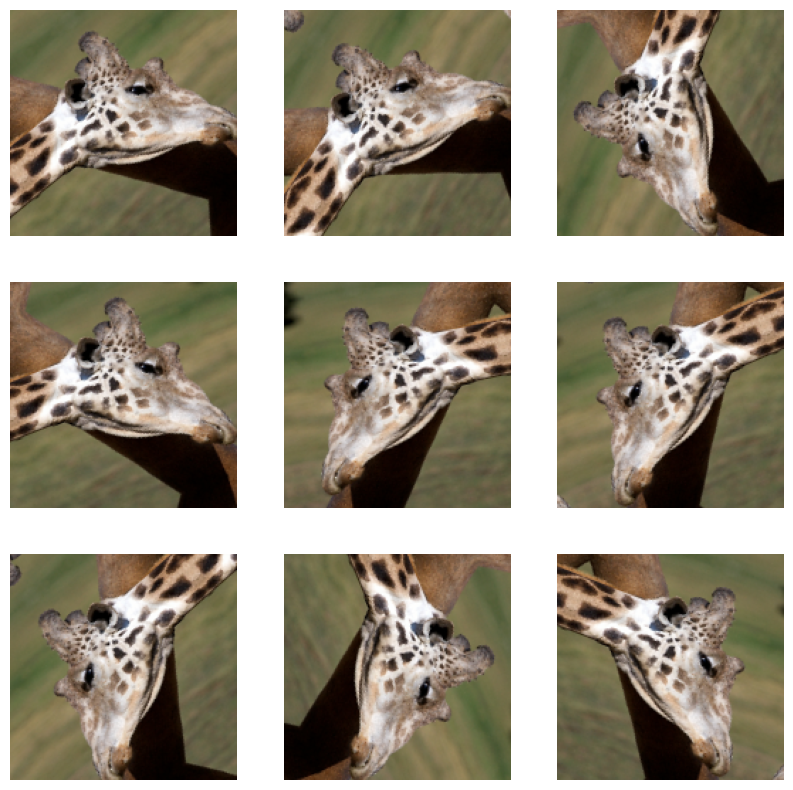

In [ ]:
data_augmentation = DataAugmenter()
print(type(data_augmentation))

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Expand image dimensions to add a batch dimension so the augmentation model can process it
        # Example: from shape (160, 160, 3) to (1, 160, 160, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0)) 
        plt.imshow(augmented_image[0] / 255) # or images[i].numpy().astype("uint8")
        plt.axis('off')

In [7]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

(160, 160)
(160, 160, 3)


In [8]:
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# The output shape is (batch_size, 1000) because MobileNetV2 is pretrained on ImageNet,
# which has 1000 classes. For each of the 32 images in the batch,
# the model outputs a vector of 1000 prediction scores—one score per ImageNet class.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(feature_batch)

9
(32, 1000)
tf.Tensor(
[[4.90656879e-04 1.07715814e-03 1.02793827e-04 ... 1.91071467e-05
  1.93771266e-04 2.24184187e-05]
 [5.16071996e-05 1.48184830e-04 1.55627669e-04 ... 3.63412400e-05
  2.76021892e-03 1.58545619e-03]
 [2.03873758e-04 2.00656534e-04 4.01641555e-05 ... 5.41301888e-05
  9.43055638e-05 4.93396146e-05]
 ...
 [1.95121276e-04 8.29994562e-04 1.23415975e-05 ... 1.58877665e-05
  5.51412697e-04 9.21022438e-05]
 [2.60141969e-05 9.51548631e-04 1.08438962e-05 ... 1.21663754e-06
  9.38797239e-05 4.95673303e-05]
 [1.65154008e-04 4.09054483e-04 2.42919210e-04 ... 1.64758138e-04
  2.67739734e-03 1.34267655e-04]], shape=(32, 1000), dtype=float32)


In [23]:
# Freeze the base model's weights so they are not updated during training
base_model.trainable = False
print(type(image_batch))
# Convert the image batch to a TensorFlow variable (needed if you want to update it or pass to model)
image_var = tf.Variable(image_batch)

# Run a forward pass through the base model to get predictions
pred = base_model(image_var)

# Decode the predictions to human-readable class names and probabilities,
# showing the top 2 predicted classes for each image in the batch
decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)
print(decoded_preds)


<class 'tensorflow.python.framework.ops.EagerTensor'>
[[('n04589890', 'window_screen', np.float32(0.42582062)), ('n02708093', 'analog_clock', np.float32(0.09275567))], [('n04589890', 'window_screen', np.float32(0.23985806)), ('n03887697', 'paper_towel', np.float32(0.14802706))], [('n04589890', 'window_screen', np.float32(0.744945)), ('n03598930', 'jigsaw_puzzle', np.float32(0.021948816))], [('n04589890', 'window_screen', np.float32(0.33546042)), ('n03530642', 'honeycomb', np.float32(0.07628951))], [('n04589890', 'window_screen', np.float32(0.2732726)), ('n03733281', 'maze', np.float32(0.08846989))], [('n04589890', 'window_screen', np.float32(0.67452383)), ('n03530642', 'honeycomb', np.float32(0.076599024))], [('n04589890', 'window_screen', np.float32(0.79128444)), ('n04209239', 'shower_curtain', np.float32(0.09241682))], [('n04589890', 'window_screen', np.float32(0.16462973)), ('n03598930', 'jigsaw_puzzle', np.float32(0.08749191))], [('n03598930', 'jigsaw_puzzle', np.float32(0.37021503

Train output layer

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=DataAugmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = Dense(1)
    
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [43]:
model = alpaca_model(IMG_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9367 - loss: 1.3051 - val_accuracy: 0.9692 - val_loss: 0.4533
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9424 - loss: 1.5725 - val_accuracy: 0.9538 - val_loss: 0.7460
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9398 - loss: 0.6823 - val_accuracy: 0.9692 - val_loss: 0.6272
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9055 - loss: 1.4623 - val_accuracy: 0.8923 - val_loss: 1.8556
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9113 - loss: 1.8113 - val_accuracy: 0.9692 - val_loss: 0.4268


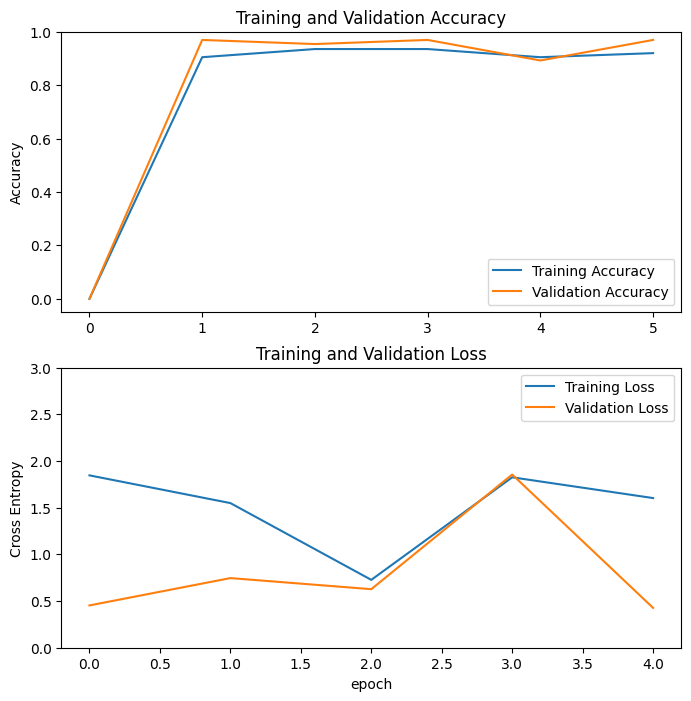

In [67]:
acc = [0.] + history.history['accuracy'] # plot from zero.
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 Fine-Tuning Selected Layers

In [68]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [69]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 126
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False

Layer input_layer_4 frozen.
Layer Conv1 frozen.
Layer bn_Conv1 frozen.
Layer Conv1_relu frozen.
Layer expanded_conv_depthwise frozen.
Layer expanded_conv_depthwise_BN frozen.
Layer expanded_conv_depthwise_relu frozen.
Layer expanded_conv_project frozen.
Layer expanded_conv_project_BN frozen.
Layer block_1_expand frozen.
Layer block_1_expand_BN frozen.
Layer block_1_expand_relu frozen.
Layer block_1_pad frozen.
Layer block_1_depthwise frozen.
Layer block_1_depthwise_BN frozen.
Layer block_1_depthwise_relu frozen.
Layer block_1_project frozen.
Layer block_1_project_BN frozen.
Layer block_2_expand frozen.
Layer block_2_expand_BN frozen.
Layer block_2_expand_relu frozen.
Layer block_2_depthwise frozen.
Layer block_2_depthwise_BN frozen.
Layer block_2_depthwise_relu frozen.
Layer block_2_project frozen.
Layer block_2_project_BN frozen.
Layer block_2_add frozen.
Layer block_3_expand frozen.
Layer block_3_expand_BN frozen.
Layer block_3_expand_relu frozen.
Layer block_3_pad frozen.
Layer bloc

In [70]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

In [71]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9462 - loss: 1.2861 - val_accuracy: 0.9538 - val_loss: 0.5233
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.9367 - loss: 0.8852 - val_accuracy: 0.9385 - val_loss: 0.7068
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9558 - loss: 0.7662 - val_accuracy: 0.9692 - val_loss: 0.4471
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9425 - loss: 0.6248 - val_accuracy: 0.9538 - val_loss: 1.0405
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9603 - loss: 0.8317 - val_accuracy: 0.9538 - val_loss: 1.0625
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9759 - loss: 0.2659 - val_accuracy: 0.9538 - val_loss: 1.1487


In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

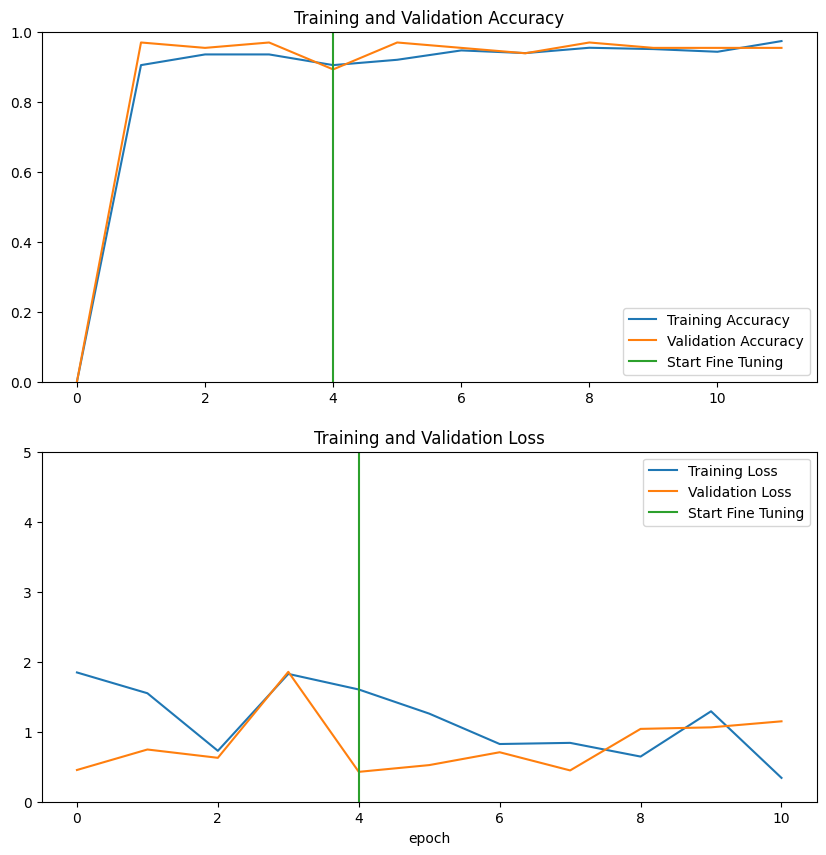

In [73]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()